In [1]:
#The only thing to include in the paper/presentation from this code is the bar graph
import random
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing
#import wfdb
import copy as cp
import scipy.signal as signal
import pickle
from sklearn import preprocessing
from tqdm import tqdm
import os
import re
import pandas as pd
import csv

from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from time import time
import timeit

random.seed(1000)

In [2]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 70 #display 70 dpi in Jupyter Notebook, may consider100 dpi 
plt.rcParams['savefig.dpi'] = 300 #define 300 dpi for saving figures

import seaborn as sns
## here are some settings 
sns.set_style('whitegrid')
sns.set(rc={"figure.dpi":70, 'savefig.dpi':300}) #defining dpi setting
sns.set_context('notebook')
sns.set_style("ticks")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

#sns.set(rc={'figure.figsize':(11.7,8.27)})

# Side to side comparison plots

In [3]:
statallfeatures_dic = {
    'Run Time': [],
    'Accuracy': [],   ## To store the MEAN accuracy for 5-fold CV for each model
    'Standard Error': [],
    'Sensitivity': [],
    'Specificity': [],
    'Precision': [],
    'F1_Score': []   
}

In [4]:
## To store the accuracy for 5-fold CV for each model
indaccs_dic = {}

2017 train -> 2021 test

In [5]:
test_df = pd.read_csv('SRER_2017_training_bi.csv', na_values='?').dropna()
train_df = pd.read_csv('JORN17_dataset_v2.csv', na_values='?').dropna()
train_df.head()
test_df.head()

,OID_,Id,gridcode,Shape_Length,Shape_Area,CH_mean,ARVI_max,ARVI_mean,ARVI_med,EVI_max,EVI_mean,EVI_med,NDVI_max,NDVI_mean,NDVI_med,SAVI_max,SAVI_mean,SAVI_med,Veg_class
0,1,2,2,41.6,17.41,0.190714,0.609099,0.344183,0.379428,0.443455,0.292047,0.290985,0.665698,0.476709,0.507514,0.406991,0.286203,0.288351,woody
1,2,3,3,31.4,5.05,0.045000,0.387755,0.245301,0.274936,0.332059,0.252919,0.244477,0.526375,0.406745,0.433791,0.328585,0.254814,0.248126,non-woody
2,3,5,5,33.4,4.84,0.010000,0.038844,0.004040,0.026805,0.150550,0.131985,0.134891,0.208300,0.181575,0.205117,0.150184,0.131642,0.135063,non-woody
3,4,6,6,32.2,14.20,0.011667,0.189842,0.033418,0.018961,0.198972,0.141579,0.138338,0.341480,0.207390,0.197327,0.197330,0.141500,0.138725,non-woody
4,5,7,7,28.8,10.73,0.013750,0.322694,0.080315,0.061453,0.248442,0.158710,0.142326,0.457103,0.247391,0.228112,0.248598,0.158618,0.142817,non-woody


In [6]:
#Logistic Regression

kf = KFold(n_splits=5, random_state=3, shuffle=True)
model = LogisticRegression(solver='liblinear')

start_time = timeit.default_timer()

acc_score = []
Truth = []
Output = []

testindex8 = []
testindex9 = []

for train_index, test_index in kf.split(train_df): 
    X_train = train_df.iloc[train_index, 5:18]
    X_test = test_df.iloc[test_index, 5:18]
    Y_train = train_df.iloc[train_index, -1]
    Y_test = test_df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)

    testindex8.append(test_index)
    testindex9.append(pred_values)
    
elapsed = timeit.default_timer() - start_time



print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statallfeatures_dic['Run Time'].append(elapsed)
statallfeatures_dic['Accuracy'].append(np.mean(acc_score))
statallfeatures_dic['Standard Error'].append(np.std(acc_score))
statallfeatures_dic['Sensitivity'].append(sensitivity)
statallfeatures_dic['Specificity'].append(specificity)
statallfeatures_dic['Precision'].append(precision)
statallfeatures_dic['F1_Score'].append(f1_score)

indaccs_dic['LogReg']=acc_score

---Run time is 0.035382900000000106 seconds ---

Accuracy of each fold: 
 [0.6452830188679245, 0.6622641509433962, 0.6716981132075471, 0.620754716981132, 0.6465028355387523]
Avg accuracy: 0.6493005671077504
Std of accuracy : 
0.017369733057241783

[[1177  176]
 [ 753  543]]

              precision    recall  f1-score   support

   non-woody       0.61      0.87      0.72      1353
       woody       0.76      0.42      0.54      1296

    accuracy                           0.65      2649
   macro avg       0.68      0.64      0.63      2649
weighted avg       0.68      0.65      0.63      2649

0.8699186991869918
0.41898148148148145
0.6098445595854922
0.7170271093512032


In [7]:
woodyarea1 = 0
nonwoodyarea1 = 0
totalarea1 = 0

start_time = timeit.default_timer()

for i in testindex8:
    for j in i:
        totalarea1 += test_df.iat[j,4]
        if test_df.iat[j,-1] == "woody":
            woodyarea1 += test_df.iat[j,4]
        if test_df.iat[j,-1] == "non-woody":
            nonwoodyarea1 += test_df.iat[j,4]

elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
needed = woodyarea1/totalarea1 * 100
print(needed)

---Run time is 0.16481369999999984 seconds ---
34.10318352293078


In [8]:
woodyarea4 = 0
nonwoodyarea4 = 0
totalarea4 = 0

start_time = timeit.default_timer()

for i in testindex8:
    for j in i:
        for k in range(0,5):
            for l in testindex9[k]:
                if l == "woody":
                    woodyarea4 += test_df.iat[j,4]
                    totalarea4 += test_df.iat[j,4]
                if l == "non-woody":
                    nonwoodyarea4 += test_df.iat[j,4]
                    totalarea4 += test_df.iat[j,4]
elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
FWC4 = woodyarea4/totalarea4 * 100
                    
print(FWC4)

---Run time is 211.4263406 seconds ---
27.142317855749877


In [9]:
#LDA
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=LinearDiscriminantAnalysis()

acc_score = []
Truth = []
Output = []

testindex1 = []
testindex2 = []
for train_index, test_index in kf.split(train_df): 
    X_train = train_df.iloc[train_index, 5:18]
    X_test = test_df.iloc[test_index, 5:18]
    Y_train = train_df.iloc[train_index, -1]
    Y_test = test_df.iloc[test_index, -1]


    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)
    
    testindex1.append(test_index)
    testindex2.append(pred_values)

elapsed = timeit.default_timer() - start_time



print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statallfeatures_dic['Run Time'].append(elapsed)
statallfeatures_dic['Accuracy'].append(np.mean(acc_score))
statallfeatures_dic['Standard Error'].append(np.std(acc_score))
statallfeatures_dic['Sensitivity'].append(sensitivity)
statallfeatures_dic['Specificity'].append(specificity)
statallfeatures_dic['Precision'].append(precision)
statallfeatures_dic['F1_Score'].append(f1_score)

indaccs_dic['LDA']=acc_score

---Run time is 211.51273510000001 seconds ---

Accuracy of each fold: 
 [0.5509433962264151, 0.5830188679245283, 0.5660377358490566, 0.5490566037735849, 0.5482041587901701]
Avg accuracy: 0.5594521525127509
Std of accuracy : 
0.013459150887711928

[[1310   43]
 [1124  172]]

              precision    recall  f1-score   support

   non-woody       0.54      0.97      0.69      1353
       woody       0.80      0.13      0.23      1296

    accuracy                           0.56      2649
   macro avg       0.67      0.55      0.46      2649
weighted avg       0.67      0.56      0.46      2649

0.9682187730968219
0.13271604938271606
0.5382087099424815
0.6918405069976235


In [10]:
woodyarea1 = 0
nonwoodyarea1 = 0
totalarea1 = 0

start_time = timeit.default_timer()

for i in testindex1:
    for j in i:
        totalarea1 += test_df.iat[j,4]
        if test_df.iat[j,-1] == "woody":
            woodyarea1 += test_df.iat[j,4]
        if test_df.iat[j,-1] == "non-woody":
            nonwoodyarea1 += test_df.iat[j,4]

elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
print(woodyarea1/totalarea1 * 100)

needed2 = woodyarea1/totalarea1 * 100
print(needed2)

---Run time is 0.17398359999998547 seconds ---
34.10318352293078
34.10318352293078


In [11]:
woodyarea1 = 0
nonwoodyarea1 = 0
totalarea1 = 0
start_time = timeit.default_timer()

for i in testindex1:
    for j in i:
        for k in range(0,5):
            for l in testindex2[k]:
                if l == "woody":
                    woodyarea1 += test_df.iat[j,4]
                    totalarea1 += test_df.iat[j,4]
                if l == "non-woody":
                    nonwoodyarea1 += test_df.iat[j,4]
                    totalarea1 += test_df.iat[j,4]

                    
elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
FWC = woodyarea1/totalarea1 * 100
                    
print(FWC)

---Run time is 216.1584941 seconds ---
8.116270290672732


In [12]:
print(woodyarea1)
print(nonwoodyarea1)
print(totalarea1)

4543433.749985884
51435896.499859884
55979330.249846734


In [13]:
#QDA
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=QuadraticDiscriminantAnalysis()

acc_score = []
Truth = []
Output = []

testindex3 = []
testindex4 = []

for train_index, test_index in kf.split(train_df): 
    X_train = train_df.iloc[train_index, 5:18]
    X_test = test_df.iloc[test_index, 5:18]
    Y_train = train_df.iloc[train_index, -1]
    Y_test = test_df.iloc[test_index, -1]


    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)


    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)
    
    #makes the list for FWC
    testindex3.append(test_index)
    testindex4.append(pred_values)

elapsed = timeit.default_timer() - start_time


print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statallfeatures_dic['Run Time'].append(elapsed)
statallfeatures_dic['Accuracy'].append(np.mean(acc_score))
statallfeatures_dic['Standard Error'].append(np.std(acc_score))
statallfeatures_dic['Sensitivity'].append(sensitivity)
statallfeatures_dic['Specificity'].append(specificity)
statallfeatures_dic['Precision'].append(precision)
statallfeatures_dic['F1_Score'].append(f1_score)

indaccs_dic['QDA']=acc_score

---Run time is 216.2191458 seconds ---

Accuracy of each fold: 
 [0.5735849056603773, 0.5849056603773585, 0.5584905660377358, 0.6018867924528302, 0.5992438563327032]
Avg accuracy: 0.5836223561722009
Std of accuracy : 
0.016196450584846155

[[ 514  839]
 [ 264 1032]]

              precision    recall  f1-score   support

   non-woody       0.66      0.38      0.48      1353
       woody       0.55      0.80      0.65      1296

    accuracy                           0.58      2649
   macro avg       0.61      0.59      0.57      2649
weighted avg       0.61      0.58      0.57      2649

0.37989652623798964
0.7962962962962963
0.6606683804627249
0.4824026278742374


In [14]:
woodyarea1 = 0
nonwoodyarea1 = 0
totalarea1 = 0

start_time = timeit.default_timer()

for i in testindex3:
    for j in i:
        totalarea1 += test_df.iat[j,4]
        if test_df.iat[j,-1] == "woody":
            woodyarea1 += test_df.iat[j,4]
        if test_df.iat[j,-1] == "non-woody":
            nonwoodyarea1 += test_df.iat[j,4]

elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
needed3 = woodyarea1/totalarea1 * 100
print(needed3)

---Run time is 0.17412910000001602 seconds ---
34.10318352293078


In [15]:
woodyarea2 = 0
nonwoodyarea2 = 0
totalarea2 = 0
start_time = timeit.default_timer()

for i in testindex3:
    for j in i:
        for k in range(0,5):
            for l in testindex4[k]:
                if l == "woody":
                    woodyarea2 += test_df.iat[j,4]
                    totalarea2 += test_df.iat[j,4]
                if l == "non-woody":
                    nonwoodyarea2 += test_df.iat[j,4]
                    totalarea2 += test_df.iat[j,4]
elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
FWC2 = woodyarea2/totalarea2 * 100
                    
print(FWC2)

---Run time is 209.1150654 seconds ---
70.63042657600987


In [16]:
print(woodyarea2)
print(nonwoodyarea2)
print(totalarea2)
print(FWC2)

39538439.74986008
16440890.499930117
55979330.249846734
70.63042657600987


#KNN-CV
KNN_result = []
X=subject_df.iloc[:, 2:17]
Y=subject_df.iloc[:, -1]
crossvalidation = KFold(n_splits=5, random_state=3, shuffle=True)
KNNResult = []
for k in range(1,26):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    model = knn.fit(X, Y)
    scores=cross_val_score(model, X, Y, cv=crossvalidation)
    print('K={}'.format(k))
    print()
    print('Accuracy of each fold: \n {}'.format(scores))
    print()
    print("Avg accuracy: {}".format(scores.mean()))
    print()
    KNN_result.append(scores.mean())
print(KNN_result)

In [17]:
KNN_result = []
X=train_df.iloc[:, 5:18]
Y=train_df.iloc[:, -1]
crossvalidation = KFold(n_splits=5, random_state=3, shuffle=True)
KNNResult = []
for k in range(1,11):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    model = knn.fit(X, Y)
    scores=cross_val_score(model, X, Y, cv=crossvalidation)
    print('K={}'.format(k))
    print()
    print('Accuracy of each fold: \n {}'.format(scores))
    print()
    print("Avg accuracy: {}".format(scores.mean()))
    print()
    KNN_result.append(scores.mean())
print(KNN_result)

K=1

Accuracy of each fold: 
 [0.72641509 0.70943396 0.72641509 0.73773585 0.72022684]

Avg accuracy: 0.7240453686200377

K=2

Accuracy of each fold: 
 [0.68867925 0.69811321 0.70754717 0.68679245 0.6899811 ]

Avg accuracy: 0.6942226343760032

K=3

Accuracy of each fold: 
 [0.72075472 0.73773585 0.76981132 0.73396226 0.74858223]

Avg accuracy: 0.742169276313443

K=4

Accuracy of each fold: 
 [0.70754717 0.75471698 0.74339623 0.70188679 0.73913043]

Avg accuracy: 0.7293355209187858

K=5

Accuracy of each fold: 
 [0.73396226 0.75471698 0.77735849 0.72830189 0.75803403]

Avg accuracy: 0.7504747298213076

K=6

Accuracy of each fold: 
 [0.72830189 0.76037736 0.77924528 0.7245283  0.731569  ]

Avg accuracy: 0.744804365659664

K=7

Accuracy of each fold: 
 [0.73773585 0.75471698 0.77735849 0.72830189 0.76181474]

Avg accuracy: 0.7519855904697363

K=8

Accuracy of each fold: 
 [0.73396226 0.75471698 0.76981132 0.72264151 0.7637051 ]

Avg accuracy: 0.7489674358882905

K=9

Accuracy of each fold

In [18]:
#KNN-CV
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=neighbors.KNeighborsClassifier(n_neighbors=9)

acc_score = []
Truth = []
Output = []

testindex5 = []
testindex6 = []

for train_index, test_index in kf.split(train_df): 
    X_train = train_df.iloc[train_index, 5:18]
    X_test = test_df.iloc[test_index, 5:18]
    Y_train = train_df.iloc[train_index, -1]
    Y_test = test_df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)
    
    testindex5.append(test_index)
    testindex6.append(pred_values)


elapsed = timeit.default_timer() - start_time

print()
print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statallfeatures_dic['Run Time'].append(elapsed)
statallfeatures_dic['Accuracy'].append(np.mean(acc_score))
statallfeatures_dic['Standard Error'].append(np.std(acc_score))
statallfeatures_dic['Sensitivity'].append(sensitivity)
statallfeatures_dic['Specificity'].append(specificity)
statallfeatures_dic['Precision'].append(precision)
statallfeatures_dic['F1_Score'].append(f1_score)

indaccs_dic['KNN']=acc_score


---Run time is 210.562385 seconds ---

Accuracy of each fold: 
 [0.5226415094339623, 0.5207547169811321, 0.5867924528301887, 0.5113207547169811, 0.5368620037807184]
Avg accuracy: 0.5356742875485965
Std of accuracy : 
0.02683288633109613

[[970 383]
 [847 449]]

              precision    recall  f1-score   support

   non-woody       0.53      0.72      0.61      1353
       woody       0.54      0.35      0.42      1296

    accuracy                           0.54      2649
   macro avg       0.54      0.53      0.52      2649
weighted avg       0.54      0.54      0.52      2649

0.7169253510716925
0.3464506172839506
0.5338470005503577
0.6119873817034701


In [19]:
woodyarea1 = 0
nonwoodyarea1 = 0
totalarea1 = 0

start_time = timeit.default_timer()

for i in testindex5:
    for j in i:
        totalarea1 += test_df.iat[j,4]
        if test_df.iat[j,-1] == "woody":
            woodyarea1 += test_df.iat[j,4]
        if test_df.iat[j,-1] == "non-woody":
            nonwoodyarea1 += test_df.iat[j,4]

elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
needed4 = woodyarea1/totalarea1 * 100
print(needed4)

---Run time is 0.16515049999998155 seconds ---
34.10318352293078


In [20]:
woodyarea3 = 0
nonwoodyarea3 = 0
totalarea3 = 0

start_time = timeit.default_timer()

for i in testindex5:
    for j in i:
        for k in range(0,5):
            for l in testindex6[k]:
                if l == "woody":
                    woodyarea3 += test_df.iat[j,4]
                    totalarea3 += test_df.iat[j,4]
                if l == "non-woody":
                    nonwoodyarea3 += test_df.iat[j,4]
                    totalarea3 += test_df.iat[j,4]

elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
FWC3 = woodyarea3/totalarea3 * 100
                    
print(FWC3)

---Run time is 211.04117569999994 seconds ---
31.40807852014127


In [21]:
transitionsdf = pd.DataFrame(
    data = np.transpose(np.array([
                                statallfeatures_dic["Accuracy"],
                                statallfeatures_dic["Standard Error"],
                                statallfeatures_dic["Sensitivity"],
                                statallfeatures_dic["Specificity"],
                                statallfeatures_dic["Precision"],
                                statallfeatures_dic["F1_Score"],
                                statallfeatures_dic["Run Time"] 
                            ])
                       ),
    
    columns = ["Accuracy", "Standard Error", "Sensitivity", "Specificity", "Precision", "F1-Score", "Run Time"]
    
)

transitionsdf.set_index(pd.Index(["LogReg", "LDA", "QDA", "KNN-CV"]))

,Accuracy,Standard Error,Sensitivity,Specificity,Precision,F1-Score,Run Time
LogReg,0.649301,0.017370,0.869919,0.418981,0.609845,0.717027,0.035383
LDA,0.559452,0.013459,0.968219,0.132716,0.538209,0.691841,211.512735
QDA,0.583622,0.016196,0.379897,0.796296,0.660668,0.482403,216.219146
KNN-CV,0.535674,0.026833,0.716925,0.346451,0.533847,0.611987,210.562385


['LogReg', 'LDA', 'QDA', 'KNN-CV']
Accuracies[0.6493005671077504, 0.5594521525127509, 0.5836223561722009, 0.5356742875485965]
Sen[0.8699186991869918, 0.9682187730968219, 0.37989652623798964, 0.7169253510716925]
Spec[0.41898148148148145, 0.13271604938271606, 0.7962962962962963, 0.3464506172839506]
P[0.6098445595854922, 0.5382087099424815, 0.6606683804627249, 0.5338470005503577]
F1[0.7170271093512032, 0.6918405069976235, 0.4824026278742374, 0.6119873817034701]


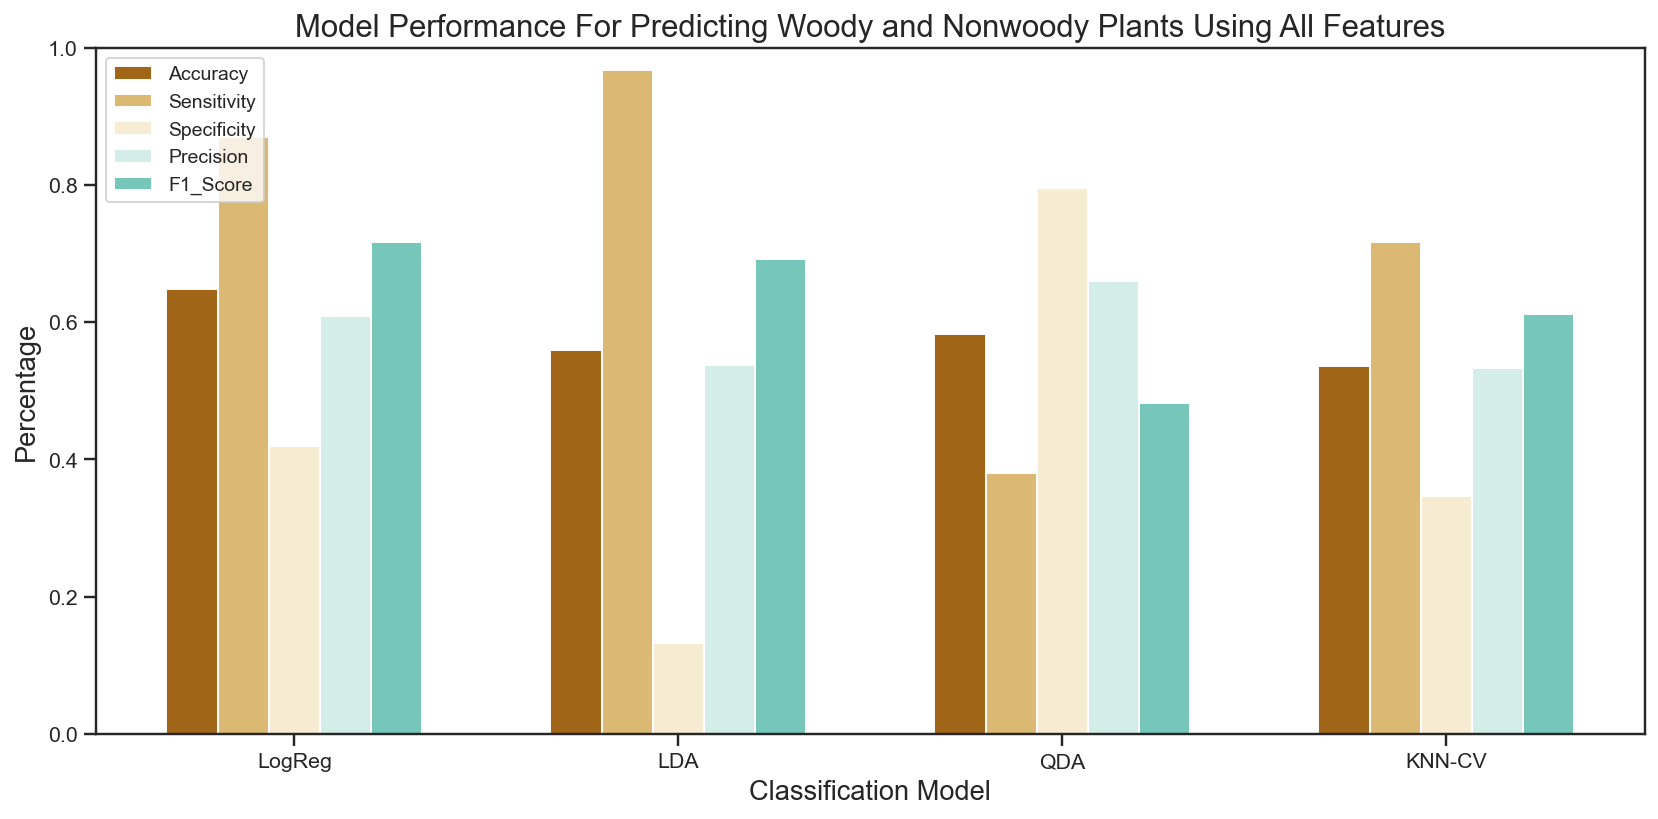

In [22]:
#Bar Graph
models = ['LogReg', 'LDA', 'QDA', 'KNN-CV']
print(models)
accuracies = statallfeatures_dic["Accuracy"]
print("Accuracies" + str(accuracies))
sensitivities = statallfeatures_dic["Sensitivity"]
print("Sen" + str(sensitivities))
specificities = statallfeatures_dic["Specificity"]
print("Spec" + str(specificities))
precisions = statallfeatures_dic["Precision"]
print("P" + str(precisions))
f1_scores = statallfeatures_dic["F1_Score"]
print("F1" + str(f1_scores))

x = 6*np.arange(len(models))
width = 0.8

fig, ax = plt.subplots(figsize=(12, 6))
import seaborn as sns
colors = sns.color_palette("BrBG")

acc = ax.bar(x-width*2, accuracies, width, label='Accuracy', color=colors[0])
sen = ax.bar(x-width, sensitivities, width, label='Sensitivity', color=colors[1])
spe = ax.bar(x,specificities, width, label='Specificity', color=colors[2])
pre = ax.bar(x+width, precisions, width, label='Precision', color=colors[3])
f1 = ax.bar(x+width*2 , f1_scores, width, label='F1_Score', color=colors[4])

ax.set_xlabel('Classification Model', fontsize=14)
ax.set_ylabel('Percentage', fontsize=14)
ax.set_title('Model Performance For Predicting Woody and Nonwoody Plants Using All Features', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.set(ylim=(0.0, 1))


fig.tight_layout()

plt.legend(loc="upper left", prop={'size': 10})
plt.show()

fig.savefig('AllFeaturesPerformance.png')

#Code from https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py

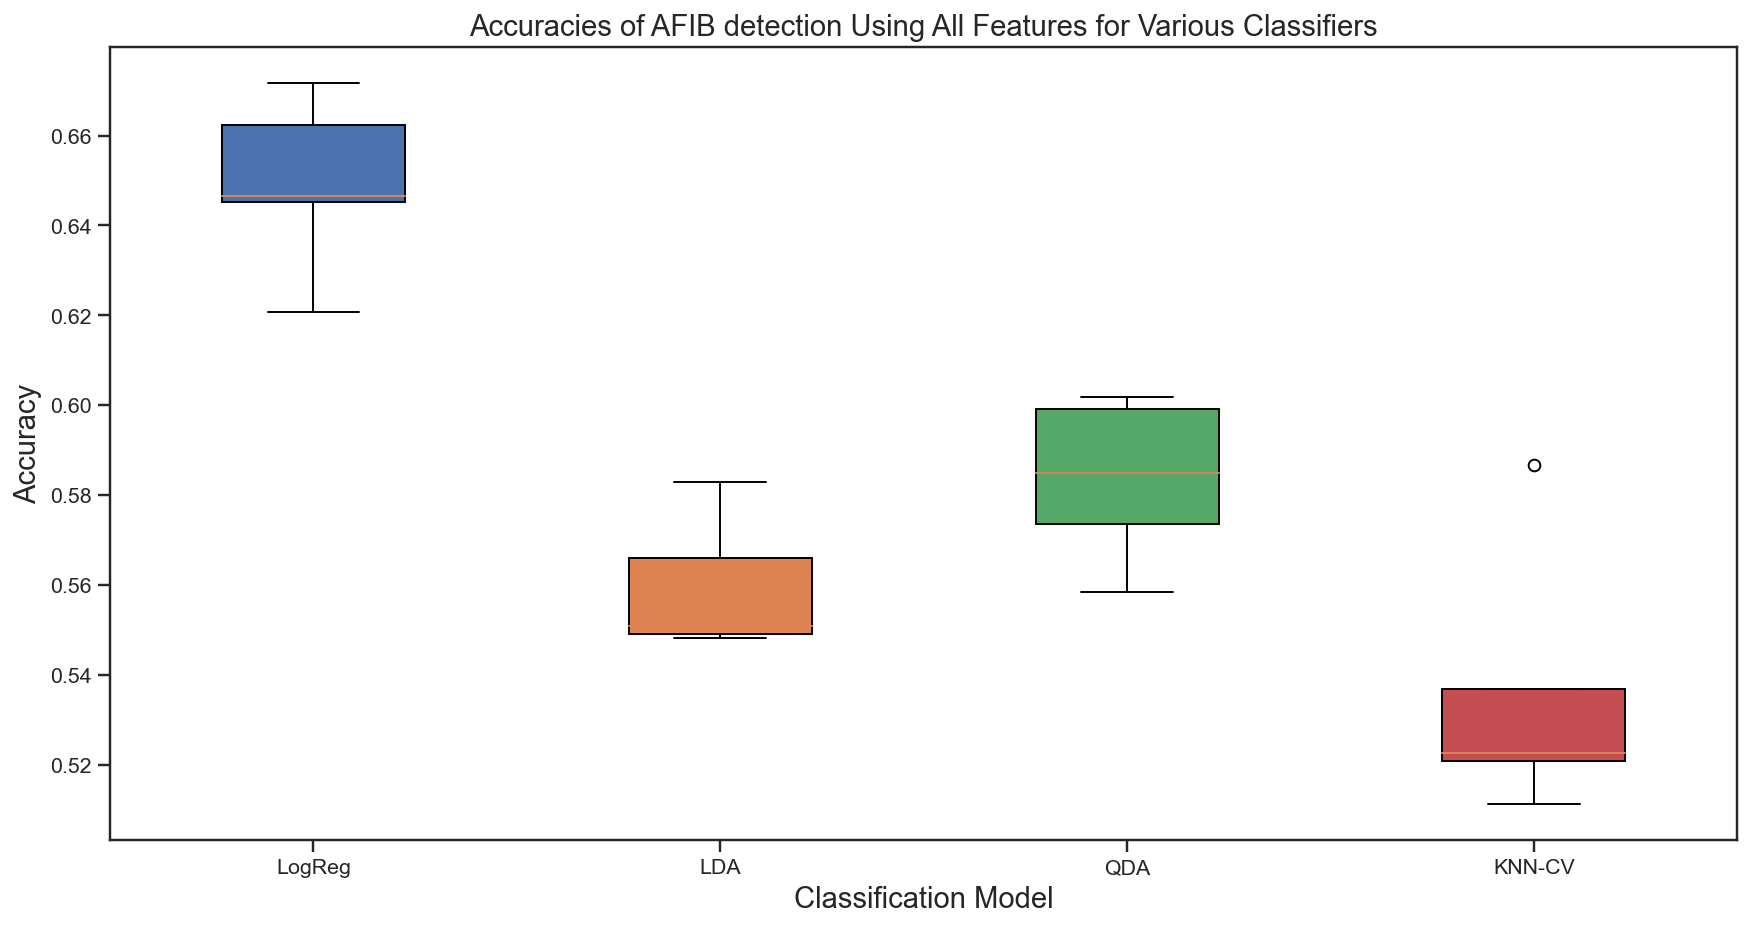

In [23]:
#Box Plot Accuracies

models = ['LogReg', 'LDA', 'QDA', 'KNN-CV']

x = np.arange(len(models))+1

LogRegAcc = indaccs_dic['LogReg']
LDAAcc = indaccs_dic['LDA']
QDAAcc = indaccs_dic['QDA']
KNNAcc = indaccs_dic['KNN']

data = [LogRegAcc, LDAAcc, QDAAcc, KNNAcc]

fig, ax = plt.subplots(figsize = (15,7.5))
bplot = ax.boxplot(data, patch_artist = True)

ax.set_title('Accuracies of AFIB detection Using All Features for Various Classifiers', fontsize=15)
ax.set_xlabel('Classification Model', fontsize=15)
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_xticks(x)
ax.set_xticklabels(models)

import seaborn as sns
#colors = sns.color_palette("colorblind")
colors = sns.color_palette()

for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
plt.show()

In [24]:
print("Log reg act: " + str(needed))
print("Log reg pred: " + str(FWC4))
print("QDA act: " + str(needed2))
print("QDA pred: " + str(FWC2))
print("LDA act: " + str(needed3))
print("LDA pred: " + str(FWC))
print("KNN act: " + str(needed4))
print("KNN pred: " +str(FWC3))

Log reg act: 34.10318352293078
Log reg pred: 27.142317855749877
QDA act: 34.10318352293078
QDA pred: 70.63042657600987
LDA act: 34.10318352293078
LDA pred: 8.116270290672732
KNN act: 34.10318352293078
KNN pred: 31.40807852014127


In [28]:
Logerrorrate = abs((needed-FWC4)/needed) *100
QDAerrorrate = abs((needed-FWC2)/needed) *100
LDAerrorrate = abs((needed-FWC)/needed) *100
KNNerrorrate = abs((needed-FWC3)/needed) *100

In [32]:
print("log ER = " + str(Logerrorrate))
print("QDA ER = " + str(QDAerrorrate))
print("LDA ER = " + str(LDAerrorrate))
print("KNN ER = " + str(KNNerrorrate))

log ER = 20.41119024122911
QDA ER = 107.10801538078809
LDA ER = 76.20084270075432
KNN ER = 7.902795939790591
